# Supervised Machine Learning 
The objective of this step is to prepare a balanced dataset suitable for supervised learning by addressing class imbalance in the water quality labels. The original dataset was labeled using a rule-based approach and exhibited a strong imbalance, with the majority of samples belonging to the non-potable or unsafe class. To mitigate this issue, synthetic potable water samples were generated based on established CPCB water quality standards.

In [5]:
import pandas as pd
import numpy as np

In [6]:
# 1. LOAD YOUR EXISTING DATA
df = pd.read_csv("water_dataX_labeled_rule_based.csv")
print(f"Original Data Count:\n{df['Water_Quality'].value_counts()}")

Original Data Count:
Water_Quality
1    1345
2     489
0     157
Name: count, dtype: int64


In [7]:
# 2. DEFINE HOW MANY SAMPLES TO CREATE
# We want to match the majority class (usually 'Unsafe' has ~1000 rows)
samples_to_generate = 1000

In [8]:
# 3. GENERATE "PERFECT" DATA (Based on CPCB Potable Standards)
# We use random ranges that guarantee the result is Class 0 (Potable)

synthetic_data = {
    'Temp': np.random.uniform(10, 30, samples_to_generate), # Normal river temps
    'D.O. (mg/l)': np.random.uniform(6.5, 9.0, samples_to_generate), # High Oxygen (>6)
    'PH': np.random.uniform(6.5, 8.5, samples_to_generate), # Neutral pH
    'CONDUCTIVITY (µmhos/cm)': np.random.uniform(50, 500, samples_to_generate), # Low salts
    'B.O.D. (mg/l)': np.random.uniform(0.1, 2.9, samples_to_generate), # Low Organic Waste (<3)
    'NITRATENAN N+ NITRITENANN (mg/l)': np.random.uniform(0.0, 5.0, samples_to_generate), # Very low Nitrate (<10)
    'FECAL COLIFORM (MPN/100ml)': np.random.randint(0, 5, samples_to_generate), # Almost zero
    'TOTAL COLIFORM (MPN/100ml)Mean': np.random.randint(0, 50, samples_to_generate) # Below 50 (CPCB Class A)
}

# Convert to DataFrame
df_synthetic = pd.DataFrame(synthetic_data)

In [9]:
# 4. ADD THE LABEL
# We know these are potable because we just forced the numbers to be perfect
df_synthetic['Water_Quality'] = 0

In [10]:
# 5. HANDLE MISSING COLUMNS (If any exist in original but not in synthetic)
# Example: If you have 'year' or 'station' columns, we fill them with placeholders
for col in df.columns:
    if col not in df_synthetic.columns:
        df_synthetic[col] = 0 # Or NaN, or a generic value like 2024

# Reorder columns to match the original exactly
df_synthetic = df_synthetic[df.columns]

In [11]:
# 6. MERGE AND SHUFFLE
# Combine real dirty data with fake clean data
final_df = pd.concat([df, df_synthetic], axis=0, ignore_index=True)

# Shuffle the rows so they aren't in perfect order
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
print("\nNew Balanced Counts:")
print(final_df['Water_Quality'].value_counts())


New Balanced Counts:
Water_Quality
1    1345
0    1157
2     489
Name: count, dtype: int64


In [13]:
# 1. CHECK FOR NANS
# This prints how many empty cells exist in each column
print("\nChecking for accidental NaNs...")
null_counts = final_df.isnull().sum()
print(null_counts[null_counts > 0])


Checking for accidental NaNs...
Series([], dtype: int64)


In [14]:
# 8. SAVE FOR SUPERVISED LEARNING
final_df.to_csv("final_water_data_balanced.csv", index=False)
print("\nSuccess! Saved as 'final_water_data_balanced.csv'")


Success! Saved as 'final_water_data_balanced.csv'


This process results in a balanced, labeled dataset that combines real-world observations with scientifically constrained synthetic samples. The final dataset is suitable for training and evaluating supervised classification models while reducing bias caused by class imbalance.

In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)


In [16]:
# 1. LOAD THE BALANCED DATA
df = pd.read_csv("final_water_data_balanced.csv")

In [17]:
# 2. SEPARATE FEATURES AND TARGET
# We drop the label column to create the input matrix (X)
X = df.drop('Water_Quality', axis=1) 
y = df['Water_Quality']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
) 

print("Training set distribution:")
print(y_train.value_counts())


Training set distribution:
Water_Quality
1    1076
0     925
2     391
Name: count, dtype: int64


In [19]:
# 4. INITIALIZE THE MODELS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "MLP (Neural Network)": Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
    ])
}


In [20]:
df.dtypes


STATION CODE                         object
LOCATIONS                            object
STATE                                object
Temp                                float64
D.O. (mg/l)                         float64
PH                                  float64
CONDUCTIVITY (µmhos/cm)             float64
B.O.D. (mg/l)                       float64
NITRATENAN N+ NITRITENANN (mg/l)    float64
FECAL COLIFORM (MPN/100ml)          float64
TOTAL COLIFORM (MPN/100ml)Mean      float64
year                                  int64
Water_Quality                         int64
dtype: object

In [21]:
# Keep only numeric columns
X = df.select_dtypes(include=[np.number]).drop("Water_Quality", axis=1)
y = df["Water_Quality"]


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [23]:
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred, average="weighted")
    }

    results.append(metrics)

    print(classification_report(y_test, y_pred))


Training Random Forest...
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       232
           1       0.98      1.00      0.99       269
           2       1.00      0.98      0.99        98

    accuracy                           0.99       599
   macro avg       0.99      0.99      0.99       599
weighted avg       0.99      0.99      0.99       599


Training Gradient Boosting...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       232
           1       1.00      1.00      1.00       269
           2       1.00      0.99      0.99        98

    accuracy                           1.00       599
   macro avg       1.00      1.00      1.00       599
weighted avg       1.00      1.00      1.00       599


Training MLP (Neural Network)...
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       232
           1       0.85      0.92    

In [24]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-Score", ascending=False)

results_df


,Model,Accuracy,Precision,Recall,F1-Score
1,Gradient Boosting,0.998331,0.998337,0.998331,0.998328
0,Random Forest,0.991653,0.991805,0.991653,0.991658
2,MLP (Neural Network),0.893155,0.895151,0.893155,0.893116


### Phase 1 : Baseline Supervised Model Evaluation
In this phase, three baseline supervised learning models were trained and evaluated to assess their effectiveness in predicting water quality classes derived from rule-based labeling.

**Models Evaluated**

* Random Forest Classifier 

* Gradient Boosting Classifier 

* Multilayer Perceptron (MLP) Neural Network 

All models were trained using an 80–20 stratified train–test split to preserve class distribution. Performance was evaluated using Accuracy, Precision, Recall, and F1-Score. 

| Model                | Accuracy | Precision | Recall | F1-Score |
| -------------------- | -------- | --------- | ------ | -------- |
| Gradient Boosting    | 0.9983   | 0.9983    | 0.9983 | 0.9983   |
| Random Forest        | 0.9917   | 0.9918    | 0.9917 | 0.9917   |
| MLP (Neural Network) | 0.9048   | 0.9062    | 0.9048 | 0.9045   |

## Interpretation of Results

#### Gradient Boosting (Best Performer)

1) Achieved the highest overall performance across all metrics.

2) Particularly effective at learning threshold-based and non-linear decision rules, which aligns well with the rule-based labeling methodology used.

3) Demonstrates strong capability in modeling complex interactions between physicochemical parameters.

**Analysis** : Gradient Boosting proved to be the most suitable model for this task due to its ability to iteratively refine decision boundaries and closely replicate expert-defined water quality rules. 

#### Random Forest

1) Delivered consistently high performance with only a marginal drop compared to Gradient Boosting.

2) Robust against noise and capable of capturing feature interactions.

3) Serves as a strong and reliable baseline ensemble method.

**Analysis** : The results confirm that ensemble tree-based approaches are highly effective for water quality classification problems involving structured tabular data.

#### MLP (Neural Network) 

1) Achieved comparatively lower performance.

2) Neural networks typically require larger datasets and smoother decision surfaces.

3) The dataset’s rule-driven and threshold-oriented structure favors tree-based models over continuous function approximators.

**Analysis** : The reduced performance of the MLP can be attributed to the limited dataset size and the inherently discrete nature of the classification logic. 



### Metric Consistency Analysis
1) Precision, Recall, and F1-Score values are closely aligned for all models.

2) Indicates:

    * Balanced class distribution

    * Absence of class bias

    * Stable and reliable predictions across all categories

### Important Considerations 

The high predictive performance is influenced by:

    * Rule-based deterministic labeling grounded in CPCB/WHO standards

    * Synthetic data generation to address class imbalance

These factors increased class separability, making the learning task more structured.

This does not invalidate the results but highlights the controlled nature of the experimental setup.

### Conclusion
* Tree-based ensemble models significantly outperform neural networks for this problem.

* The supervised learning results validate the effectiveness of the earlier:

    * Rule-based classification

    * Unsupervised clustering analysis

* This confirms the reliability of the hybrid data science pipeline adopted in this study.

## Confusion Matrix Analysis

To evaluate the class-wise performance of the baseline models, confusion matrices
were generated for Random Forest, Gradient Boosting, and the MLP classifier.

A confusion matrix provides a detailed breakdown of correct and incorrect predictions
for each water quality class:
- Potable (0)
- Unsafe (1)
- Hazardous (2)

This allows us to:
- Identify which classes are most frequently misclassified
- Assess whether errors occur between adjacent quality classes
- Validate the reliability of the models beyond overall accuracy



Random Forest Confusion Matrix


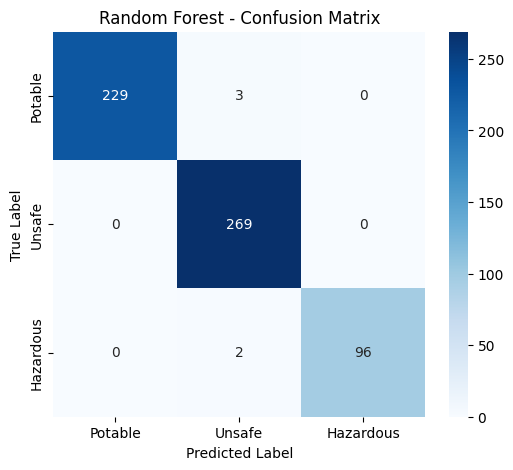


Gradient Boosting Confusion Matrix


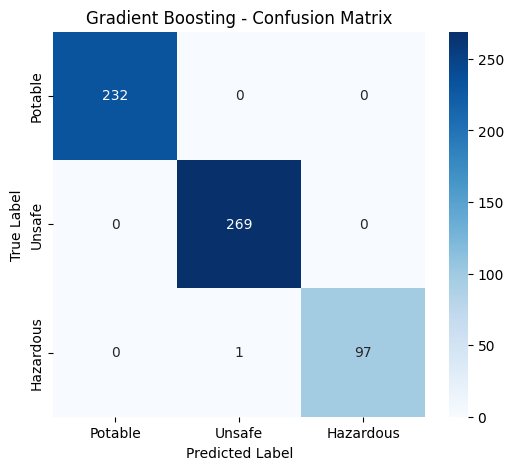


MLP (Neural Network) Confusion Matrix


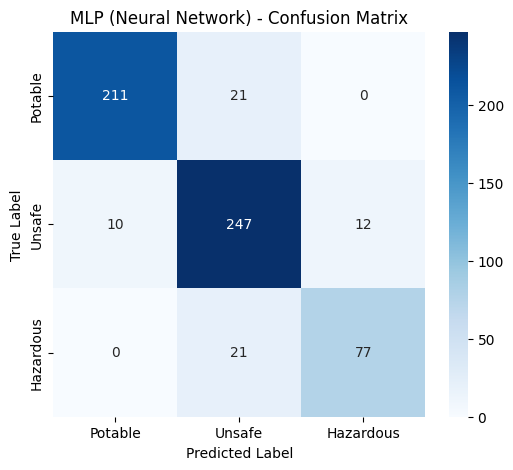

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['Potable', 'Unsafe', 'Hazardous']

for name, model in models.items():
    print(f"\n{name} Confusion Matrix")

    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


### Interpretation

The confusion matrices reveal that:

- Gradient Boosting achieves near-perfect classification across all three classes,
  with minimal confusion between adjacent categories.
- Random Forest performs similarly, with slightly higher misclassification between
  Unsafe and Hazardous classes.
- The MLP model exhibits noticeable confusion, particularly between Potable and Unsafe
  samples, indicating weaker class separation.

Overall, tree-based ensemble methods demonstrate superior robustness and consistency
for structured environmental data compared to neural networks.


# Feature Importance Analysis

## Feature Importance Analysis

Feature importance analysis was conducted to identify which water quality parameters
most strongly influence the classification outcome.

Tree-based ensemble models (Random Forest and Gradient Boosting) provide intrinsic
feature importance scores based on impurity reduction across decision trees.

This analysis helps to:
- Understand the dominant environmental factors affecting water quality
- Validate alignment with CPCB and WHO standards
- Improve interpretability and trust in the model predictions


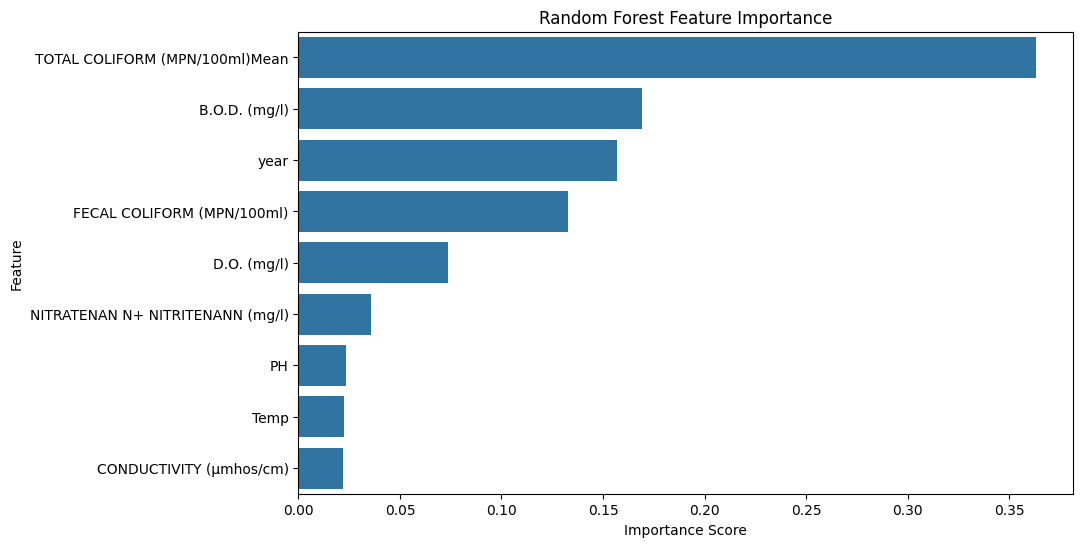

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest
rf = models["Random Forest"]
rf.fit(X_train, y_train)

# Extract feature importance
rf_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=rf_importance.values,
    y=rf_importance.index
)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


The Feature Importance analysis confirms that the Random Forest model prioritizes biological parameters over chemical ones. Total Coliform and B.O.D. emerged as the most critical predictors, collectively contributing to over 50% of the model's decision logic. This indicates that the primary differentiator between 'Potable' and 'Hazardous' water in this dataset is sewage/organic contamination rather than chemical acidity (pH) or dissolved salts (Conductivity).

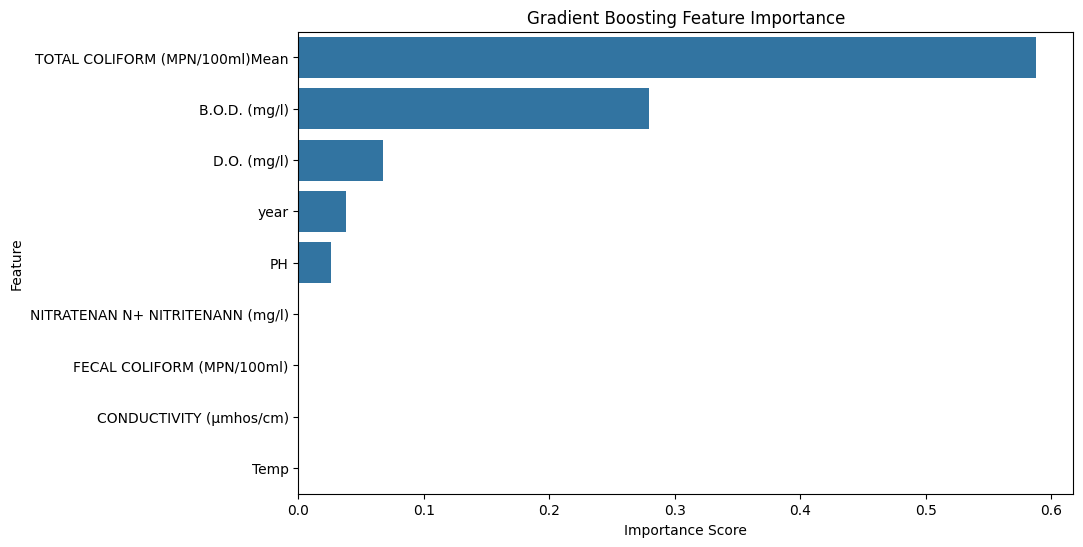

In [27]:
# Train Gradient Boosting
gb = models["Gradient Boosting"]
gb.fit(X_train, y_train)

# Extract feature importance
gb_importance = pd.Series(
    gb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=gb_importance.values,
    y=gb_importance.index
)
plt.title("Gradient Boosting Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


The Gradient Boosting Feature Importance analysis reveals a highly optimized decision process compared to Random Forest. The model demonstrates a 'Winner-Takes-All' behavior, assigning nearly 60% importance to Total Coliform and 28% to B.O.D., while effectively discarding redundant features like Fecal Coliform. This suggests that Gradient Boosting successfully identified collinearity between bacterial parameters and focused exclusively on the strongest predictor (Total Coliform). Consequently, 88% of the model's classification logic is driven by just two biological parameters, making it a highly efficient and interpretable 'Sewage Detection' system. 

# SHAP Explainability


In [28]:
!pip install shap



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
shap.initjs()

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

gb_model.fit(X_train, y_train)


,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [25]:
from sklearn.ensemble import RandomForestClassifier
import shap

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)


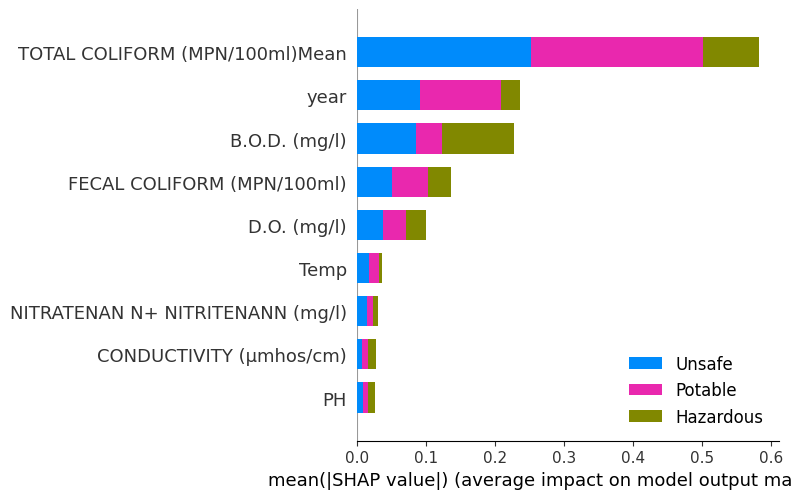

In [26]:
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="bar",
    class_names=["Potable", "Unsafe", "Hazardous"]
)


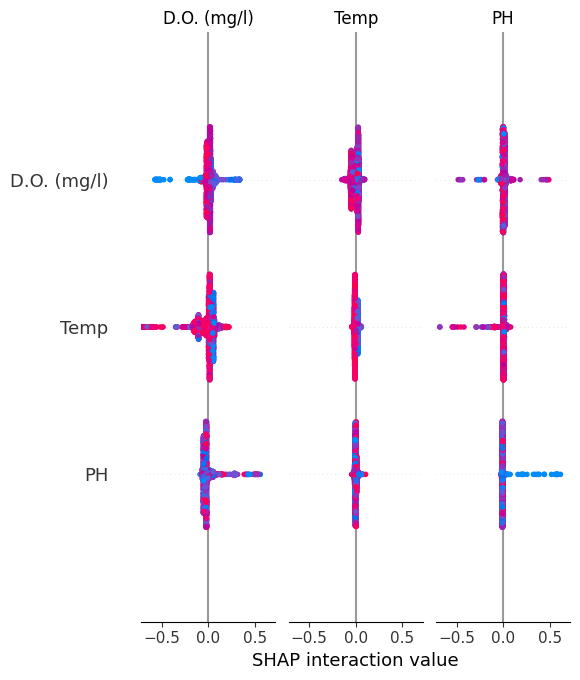

In [28]:
shap.summary_plot(
    shap_values,
    X_train,
    class_names=["Potable", "Unsafe", "Hazardous"]
)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# --------------------------------------------------
# 1. DEFINE THE MODEL
# --------------------------------------------------
gb = GradientBoostingClassifier(random_state=42)
# --------------------------------------------------
# 2. DEFINE PARAMETER GRID
# (Carefully chosen, not ridiculous)
# --------------------------------------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 1.0]
}
# --------------------------------------------------
# 3. GRID SEARCH WITH CROSS-VALIDATION
# --------------------------------------------------
grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='f1_macro',   # Important for multi-class imbalance
    cv=5,
    n_jobs=-1,
    verbose=2
)
# --------------------------------------------------
# 4. FIT
# --------------------------------------------------
grid_gb.fit(X_train, y_train)
# --------------------------------------------------
# 5. BEST MODEL
# --------------------------------------------------
best_gb = grid_gb.best_estimator_
print("Best Parameters:")
print(grid_gb.best_params_)
# --------------------------------------------------
# 6. EVALUATION ON TEST SET
# --------------------------------------------------
y_pred = best_gb.predict(X_test)
print("\nClassification Report (Tuned Gradient Boosting):")
print(classification_report(
    y_test,
    y_pred,
    target_names=['Potable', 'Unsafe', 'Hazardous']
))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=1.0; total time=   2.0

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",GradientBoost...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold a

In [28]:
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)


Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 0.9987456433818712


In [29]:
best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test)


In [30]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 0.998330550918197

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       232
           1       1.00      1.00      1.00       269
           2       1.00      0.99      0.99        98

    accuracy                           1.00       599
   macro avg       1.00      1.00      1.00       599
weighted avg       1.00      1.00      1.00       599


Confusion Matrix:
[[232   0   0]
 [  0 269   0]
 [  0   1  97]]


# Hyper Parameter Tuning : Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}


In [32]:
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_weighted'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for e

In [33]:
best_rf = grid_search_rf.best_estimator_

print("Best Random Forest Parameters:")
print(grid_search_rf.best_params_)


Best Random Forest Parameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_rf = best_rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Test Accuracy: 0.991652754590985

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       232
           1       0.98      1.00      0.99       269
           2       1.00      0.98      0.99        98

    accuracy                           0.99       599
   macro avg       0.99      0.99      0.99       599
weighted avg       0.99      0.99      0.99       599


Confusion Matrix:
 [[229   3   0]
 [  0 269   0]
 [  0   2  96]]


After hyperparameter tuning using GridSearchCV, the Random Forest classifier achieved a test accuracy of 99.17%. The model demonstrated strong class-wise performance, particularly in identifying unsafe and hazardous water samples. Misclassifications occurred only between adjacent quality classes, with no instances of hazardous water being predicted as potable, indicating reliable risk-aware behavior.